# Imports

In [1]:
import os
import sys

import numpy as np
import tensorflow as tf

import keras
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing as sk_pre
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from joblib import dump, load
import importlib

proj_dir = os.path.split(os.getcwd())[0]
if proj_dir not in sys.path:
    sys.path.append(proj_dir)
import src.models.model_arch as arch
import src.visualization.visualize as vis

# Data


|Метка|Класс|
|:-----:|:-----|
|0|T-shirt (Футболка)|
|1|Trouser (Брюки)|
|2|Pullover (Свитер)|
|3|Dress (Платье)|
|4|Coat (Пальто)|
|5|Sandal (Сандали)|
|6|Shirt (Рубашка)|
|7|Sneaker (Кроссовки)|
|8|Bag (Сумка)|
|9|Ankle boot (Ботильоны)|

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_imgs, train_labels), (test_imgs, test_labels) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
print("Train shapes:")
print(train_imgs.shape)
print(train_labels.shape, "\n")
print("Test shapes:")
print(test_imgs.shape)
print(test_labels.shape)

Train shapes:
(60000, 28, 28)
(60000,) 

Test shapes:
(10000, 28, 28)
(10000,)


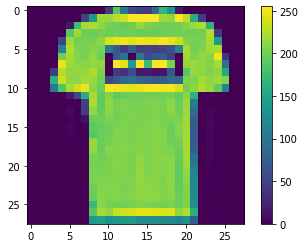

In [6]:
plt.imshow(train_imgs[1])
plt.colorbar()
plt.show()

In [7]:
train_imgs = train_imgs / 255
test_imgs = test_imgs / 255

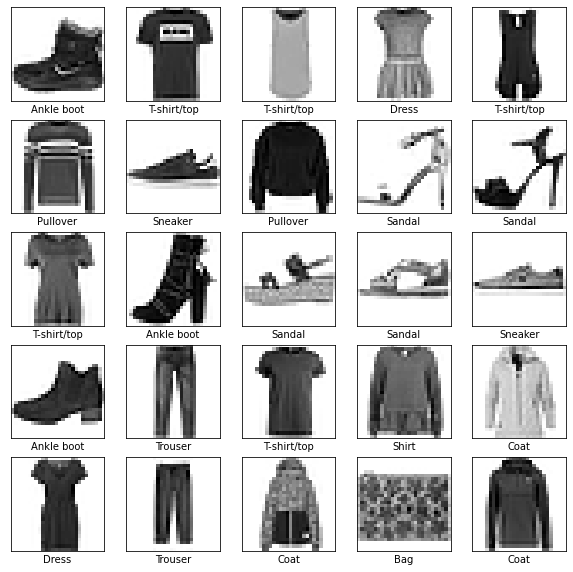

In [8]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_imgs[i], cmap='binary')
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [9]:
clf_train = (train_imgs).reshape((60000, 28*28))
clf_test = (test_imgs).reshape((10000, 28*28))

## Augmentation

# Simple dense model

In [10]:
importlib.reload(arch)

<module 'src.models.model_arch' from '/Users/laptevartem/Repositories/fashionMNIST_experiments/src/models/model_arch.py'>

In [11]:
dense_model = arch.dense_model()
dense_model.compile(optimizer='Adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
dense_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_______________________________________________________

Epoch 1/50
193/193 [==============================] - 3s 12ms/step - loss: 1.0970 - accuracy: 0.6144 - val_loss: 0.5178 - val_accuracy: 0.8156
Epoch 2/50
193/193 [==============================] - 1s 7ms/step - loss: 0.5704 - accuracy: 0.7969 - val_loss: 0.4549 - val_accuracy: 0.8351
Epoch 3/50
193/193 [==============================] - 1s 7ms/step - loss: 0.5056 - accuracy: 0.8211 - val_loss: 0.4166 - val_accuracy: 0.8519
Epoch 4/50
193/193 [==============================] - 1s 6ms/step - loss: 0.4781 - accuracy: 0.8288 - val_loss: 0.4052 - val_accuracy: 0.8522
Epoch 5/50
193/193 [==============================] - 1s 6ms/step - loss: 0.4483 - accuracy: 0.8374 - val_loss: 0.3938 - val_accuracy: 0.8601
Epoch 6/50
193/193 [==============================] - 1s 6ms/step - loss: 0.4340 - accuracy: 0.8415 - val_loss: 0.3872 - val_accuracy: 0.8604
Epoch 7/50
193/193 [==============================] - 2s 8ms/step - loss: 0.4380 - accuracy: 0.8399 - val_loss: 0.3751 - val_accuracy: 0.8686
Epoch

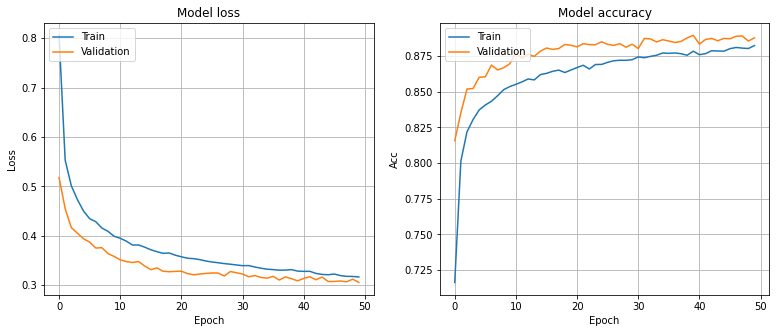

CPU times: user 1min 55s, sys: 9.78 s, total: 2min 4s
Wall time: 1min 13s


In [12]:
%%time
cb = [
    ModelCheckpoint(filepath="../models/dense_arch_best_loss.h5",
                    monitor='val_loss',
                    save_best_only=True,
    ),
    ModelCheckpoint(filepath="../models/dense_arch_best_acc.h5",
                    monitor='val_accuracy',
                    save_best_only=True,
    ),
    EarlyStopping(monitor='val_loss',
                  patience=5,
    )
]

history_dense = dense_model.fit(train_imgs.reshape(60000, 28, 28, 1),
                    train_labels,
                    epochs=50, validation_split=0.18, batch_size=256, callbacks=cb)

vis.plot_loss_graph(history_dense)

In [13]:
dense_model.save("../models/dense_arch_last.h5")

In [14]:
dense_model = keras.models.load_model("../models/dense_arch_best_loss.h5")

In [15]:
test_loss, test_acc = dense_model.evaluate(test_imgs.reshape(10000, 28, 28, 1), test_labels)
print('Test accuracy:', test_acc)
#print('Test loss:', test_loss)
dense_acc = test_acc

313/313 [==============================] - 0s 1ms/step - loss: 0.3268 - accuracy: 0.8840
Test accuracy: 0.8840000033378601


# Convolutional Model

In [16]:
importlib.reload(arch)

<module 'src.models.model_arch' from '/Users/laptevartem/Repositories/fashionMNIST_experiments/src/models/model_arch.py'>

In [17]:
conv_model = arch.conv_model()
conv_model.compile(optimizer='Adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
conv_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0   

Epoch 1/40
193/193 [==============================] - 45s 232ms/step - loss: 1.2608 - accuracy: 0.5365 - val_loss: 0.5260 - val_accuracy: 0.7998
Epoch 2/40
193/193 [==============================] - 53s 265ms/step - loss: 0.5590 - accuracy: 0.7875 - val_loss: 0.4361 - val_accuracy: 0.8324
Epoch 3/40
193/193 [==============================] - 42s 219ms/step - loss: 0.4757 - accuracy: 0.8222 - val_loss: 0.3804 - val_accuracy: 0.8549
Epoch 4/40
193/193 [==============================] - 42s 219ms/step - loss: 0.4179 - accuracy: 0.8452 - val_loss: 0.3417 - val_accuracy: 0.8742
Epoch 5/40
193/193 [==============================] - 41s 214ms/step - loss: 0.3730 - accuracy: 0.8633 - val_loss: 0.3146 - val_accuracy: 0.8822
Epoch 6/40
193/193 [==============================] - 46s 239ms/step - loss: 0.3513 - accuracy: 0.8719 - val_loss: 0.2959 - val_accuracy: 0.8883
Epoch 7/40
193/193 [==============================] - 42s 220ms/step - loss: 0.3357 - accuracy: 0.8777 - val_loss: 0.2939 - val_ac

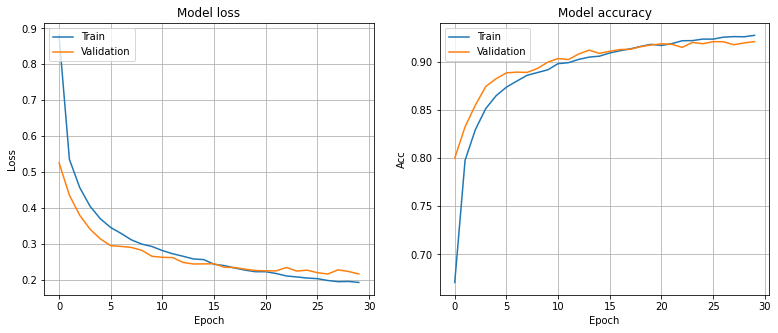

CPU times: user 53min 51s, sys: 10min 59s, total: 1h 4min 50s
Wall time: 21min 21s


In [18]:
%%time
cb = [
    ModelCheckpoint(filepath="../models/conv_arch_best_loss.h5",
                    monitor='val_loss',
                    save_best_only=True,
    ),
    ModelCheckpoint(filepath="../models/conv_arch_best_acc.h5",
                    monitor='val_accuracy',
                    save_best_only=True,
    ),
    EarlyStopping(monitor='val_loss',
                  patience=3,
    )
]

history_conv = conv_model.fit(train_imgs.reshape(60000, 28, 28, 1),
                              train_labels,
                              epochs=40,
                              validation_split=0.18,
                              batch_size=256, callbacks=cb)

vis.plot_loss_graph(history_conv)

In [19]:
conv_model.save("../models/conv_arch_last.h5")

In [20]:
conv_model = keras.models.load_model("../models/conv_arch_best_acc.h5")

In [21]:
test_loss, test_acc = conv_model.evaluate(test_imgs.reshape(10000, 28, 28, 1), test_labels)
print('Test accuracy:', test_acc)
#print('Test loss:', test_loss)
conv_acc = test_acc

313/313 [==============================] - 2s 7ms/step - loss: 0.2312 - accuracy: 0.9177
Test accuracy: 0.9176999926567078


# Model with SeparableConv Layers

In [22]:
importlib.reload(arch)

<module 'src.models.model_arch' from '/Users/laptevartem/Repositories/fashionMNIST_experiments/src/models/model_arch.py'>

In [23]:
sep_model = arch.separableconv_model()
sep_model.compile(optimizer='Adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
sep_model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
separable_conv2d (SeparableC (None, 26, 26, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 11, 11, 64)        2400

Epoch 1/40
193/193 [==============================] - 67s 342ms/step - loss: 1.1348 - accuracy: 0.5804 - val_loss: 2.3994 - val_accuracy: 0.0968
Epoch 2/40
193/193 [==============================] - 64s 332ms/step - loss: 0.4913 - accuracy: 0.8199 - val_loss: 2.3388 - val_accuracy: 0.0968
Epoch 3/40
193/193 [==============================] - 64s 329ms/step - loss: 0.4118 - accuracy: 0.8514 - val_loss: 0.6073 - val_accuracy: 0.8088
Epoch 4/40
193/193 [==============================] - 64s 332ms/step - loss: 0.3610 - accuracy: 0.8692 - val_loss: 0.3449 - val_accuracy: 0.8719
Epoch 5/40
193/193 [==============================] - 64s 329ms/step - loss: 0.3390 - accuracy: 0.8796 - val_loss: 0.3362 - val_accuracy: 0.8776
Epoch 6/40
193/193 [==============================] - 64s 330ms/step - loss: 0.3210 - accuracy: 0.8847 - val_loss: 0.2898 - val_accuracy: 0.8923
Epoch 7/40
193/193 [==============================] - 64s 330ms/step - loss: 0.3113 - accuracy: 0.8885 - val_loss: 0.2659 - val_ac

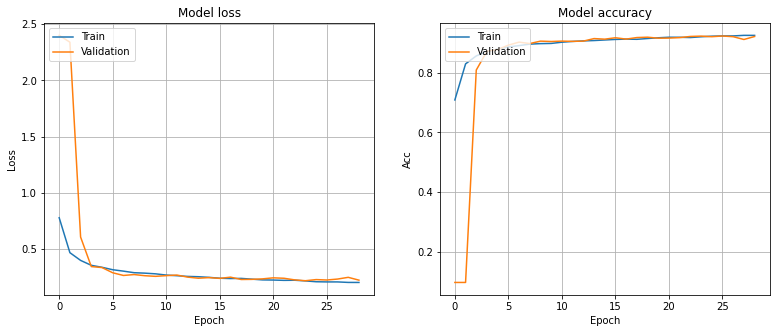

CPU times: user 1h 24min 18s, sys: 15min 51s, total: 1h 40min 10s
Wall time: 30min 57s


In [24]:
%%time
cb = [
    ModelCheckpoint(filepath="../models/sep_arch_best_loss.h5",
                    monitor='val_loss',
                    save_best_only=True,
    ),
    ModelCheckpoint(filepath="../models/sep_arch_best_acc.h5",
                    monitor='val_accuracy',
                    save_best_only=True,
    ),
    EarlyStopping(monitor='val_loss',
                  patience=5,
    )
]

history_sep = sep_model.fit(train_imgs.reshape(60000, 28, 28, 1),
                              train_labels,
                              epochs=40,
                              validation_split=0.18,
                              batch_size=256, callbacks=cb)

vis.plot_loss_graph(history_sep)


In [25]:
sep_model.save("../models/sep_arch_last.h5")

In [26]:
sep_model = keras.models.load_model("../models/sep_arch_best_acc.h5")

In [27]:
test_loss, test_acc = sep_model.evaluate(test_imgs.reshape(10000, 28, 28, 1), test_labels)
print('Test accuracy:', test_acc)
#print('Test loss:', test_loss)
sep_acc = test_acc

313/313 [==============================] - 6s 16ms/step - loss: 0.2450 - accuracy: 0.9170
Test accuracy: 0.9169999957084656


# logistic regression

In [33]:
log_clf = LogisticRegression(solver='lbfgs',
                         max_iter=100,
                         multi_class='auto')

In [34]:
%%time
log_clf.fit(clf_train, train_labels)

CPU times: user 49.1 s, sys: 693 ms, total: 49.8 s
Wall time: 25 s


/Users/laptevartem/Repositories/fashionMNIST_experiments/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [35]:
dump(log_clf, "../models/logit_model.joblib")
#log_clf = load("../models/logit_model.joblib")

['../models/logit_model.joblib']

In [61]:
log_acc = log_clf.score(clf_test, test_labels)
print(log_acc)

0.8439


In [37]:
log_clf.score(clf_train, train_labels)

0.86625

## Dim reduction

In [38]:
pca = PCA(n_components=200)

clf_train_pca = pca.fit_transform(clf_train)
clf_test_pca = pca.transform(clf_test)

In [39]:
scaler = sk_pre.StandardScaler().fit(clf_train_pca)

clf_train_pca_scaled = scaler.transform(clf_train_pca)
clf_test_pca_scaled = scaler.transform(clf_test_pca)

In [40]:
pca_log_clf = LogisticRegression(max_iter=1000)
#pca_clf = LinearSVC(max_iter=1000, C=10)

In [41]:
%%time
pca_log_clf.fit(clf_train_pca_scaled, train_labels)

CPU times: user 52.6 s, sys: 2.05 s, total: 54.6 s
Wall time: 27.5 s


LogisticRegression(max_iter=1000)

In [44]:
dump(pca_log_clf, "../models/pca_logit_model.joblib")
#pca_log_clf = load("../models/pca_logit_model.joblib")

['../models/pca_logit_model.joblib']

In [62]:
pca_log_acc = pca_log_clf.score(clf_test_pca_scaled, test_labels)
print(pca_log_acc)

0.8434


In [43]:
pca_log_clf.score(clf_train_pca_scaled, train_labels)

0.86665

# SVM

In [45]:
svm_clf = LinearSVC()

In [46]:
%%time
svm_clf.fit(clf_train, train_labels)

CPU times: user 4min 15s, sys: 1.46 s, total: 4min 16s
Wall time: 4min 21s


/Users/laptevartem/Repositories/fashionMNIST_experiments/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC()

In [47]:
dump(svm_clf, "../models/svm_model.joblib")
#svm_clf = load("../models/svm_model.joblib")

['../models/svm_model.joblib']

In [63]:
svm_acc = svm_clf.score(clf_test, test_labels)
print(svm_acc)

0.8394


In [49]:
svm_clf.score(clf_train, train_labels)

0.8724833333333334

# Gradient Boosting

In [50]:
gb_clf = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=7)

In [51]:
%%time
gb_clf.fit(clf_train, train_labels)

CPU times: user 2h 4min 15s, sys: 15.7 s, total: 2h 4min 31s
Wall time: 2h 5min 9s


GradientBoostingClassifier(max_depth=7, n_estimators=50)

In [52]:
dump(gb_clf, "../models/gb_model.joblib")
#gb_clf = load("../models/gb_model.joblib")

['../models/gb_model.joblib']

In [64]:
gb_acc = gb_clf.score(clf_test, test_labels)
print(gb_acc)

0.8768


In [54]:
gb_clf.score(clf_train, train_labels)

0.9856833333333334

# Model ensembling

In [55]:
log_clf_pred = log_clf.predict_proba(clf_test)
gb_clf_pred = gb_clf.predict_proba(clf_test)
pca_log_pred = pca_log_clf.predict_proba(clf_test_pca_scaled)

conv_pred = conv_model.predict(test_imgs.reshape(10000, 28, 28, 1))

In [56]:
ensem_pred = 0.1 * log_clf_pred + 0.1 * gb_clf_pred + 0.1 * pca_log_pred + 0.97 * conv_pred
ensem_pred.shape

(10000, 10)

In [65]:
ensem_acc = (ensem_pred.argmax(axis=-1)==test_labels).sum()/10000
print(ensem_acc)

0.9177


# Metrics comparison

In [69]:
print('Dense Model accuracy:', round(dense_acc, 4))
print('Conv Model accuracy:', round(conv_acc, 4))
print('Separable Conv accuracy:', round(sep_acc, 4))
print('Logistic Regression accuracy:', log_acc)
print('Logistic Regression with PCA accuracy:', pca_log_acc)
print('LinearSVC accuracy:', svm_acc)
print('GB accuracy:', gb_acc)
print('Ensemble accuracy:', ensem_acc)


#predicted_classes = conv_model.predict(test_imgs.reshape(10000, 28, 28, 1)).argmax(axis=-1)
#target_names = ["Class {}".format(i) for i in class_names]
#print(classification_report(test_labels, predicted_classes, target_names=target_names))

Dense Model accuracy: 0.8768
Conv Model accuracy: 0.9175
Separable Conv accuracy: 0.9158
Logistic Regression accuracy: 0.8439
Logistic Regression with PCA accuracy: 0.8434
LinearSVC accuracy: 0.8394
GB accuracy: 0.8768
Ensemble accuracy: 0.9177


# Let's look at predictions

In [29]:
predictions = conv_model.predict(test_imgs.reshape(10000, 28, 28, 1))

In [30]:
predictions[0]

array([2.9763579e-14, 1.6660662e-15, 8.3561901e-15, 8.0928363e-13,
       6.9426648e-13, 9.9746828e-08, 5.4936000e-16, 6.0037746e-06,
       2.8702162e-12, 9.9999392e-01], dtype=float32)

In [31]:
np.argmax(predictions[0])

9

In [32]:
test_labels[0]

9

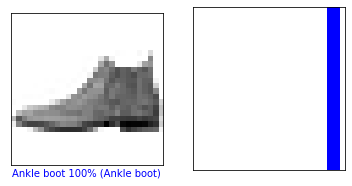

In [93]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
vis.plot_image(predictions[i], test_labels[i], test_imgs[i], class_names)
plt.subplot(1,2,2)
vis.plot_value_array(predictions[i],  test_labels[i])
plt.show()

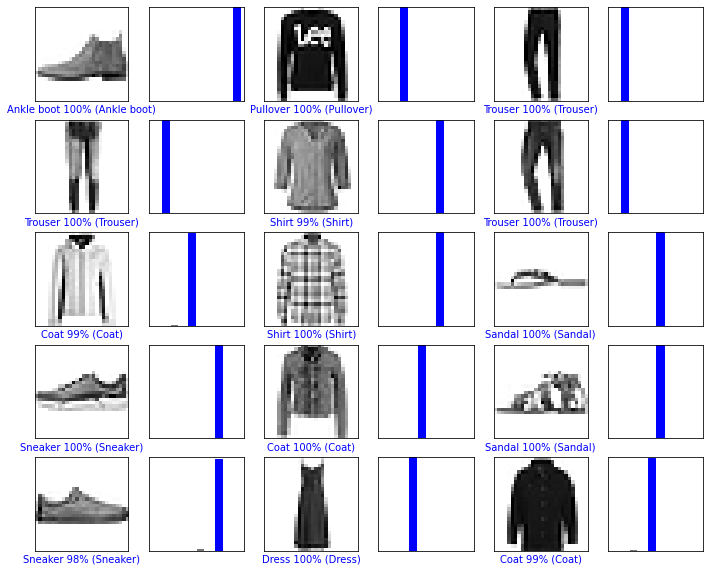

In [34]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    vis.plot_image(predictions[i], test_labels[i], test_imgs[i], class_names)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    vis.plot_value_array(predictions[i], test_labels[i])
plt.show()

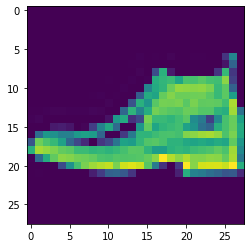

In [35]:
img = test_imgs[4567]
plt.imshow(img)
plt.show()

In [36]:
print(img.shape)
img = (np.expand_dims(img, 0))
print(img.shape)

(28, 28)
(1, 28, 28)


In [38]:
single_prediction = conv_model.predict(img.reshape(1, 28, 28, 1))
single_prediction

array([[1.23144816e-15, 6.21645752e-18, 5.71981960e-17, 1.05222964e-14,
        1.74712302e-14, 2.20634022e-09, 1.31733424e-18, 1.71085006e-07,
        4.23091385e-13, 9.99999881e-01]], dtype=float32)

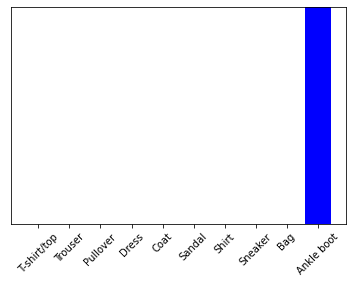

In [39]:
vis.plot_value_array(single_prediction.flatten(), test_labels[4567])
plt.xticks(range(10), class_names, rotation=45)
plt.show()